## Exploratory data analysis

Importing the required modules

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

## Reading the dataset and deriving useful time-related features

In [9]:
#reading the dataset
url="https://raw.githubusercontent.com/MariaStamouli/Energy-Prediction/master/energydata_complete.csv"
my_DF=pd.read_csv(url,index_col=0,parse_dates=[0])

#adding some extra columns derived from the date
my_DF.loc[:,"hour"]=my_DF.index.hour
my_DF.loc[:,"day of the week"]=my_DF.index.dayofweek

#adding weekend flag
my_DF.loc[my_DF.loc[:,"day of the week"]>4,"weekend"]=1
my_DF.loc[my_DF.loc[:,"day of the week"]<5,"weekend"]=0

#adding the working hours
my_DF.loc[:,"working hours"]=1
my_DF.loc[my_DF.loc[:,"day of the week"]>4,"working hours"]=0
my_DF.loc[my_DF.loc[:,"hour"]>17,"working hours"]=0
my_DF.loc[my_DF.loc[:,"hour"]<10,"working hours"]=0

#adding other data available from the date
my_DF.loc[:,"Month"]=my_DF.index.month

#generating some lagged columns to check if we can increase the correlation between the appliances and temperatures.
def laggedcolumncreator(df,parameter,lag_start,lag_end,lag_interval):
  for i in list(range(lag_start,lag_end,lag_interval)):
      laggedcolumn=parameter+"-"+str(i)+"min"
      df[laggedcolumn]=df[parameter].shift(i)
  return(df)

laggedcolumncreator(my_DF,"T1",20,121,20)
laggedcolumncreator(my_DF,"T2",20,121,20)
laggedcolumncreator(my_DF,"T3",20,121,20)
laggedcolumncreator(my_DF,"T4",20,121,20)
laggedcolumncreator(my_DF,"T5",20,121,20)
laggedcolumncreator(my_DF,"T6",20,121,20)
laggedcolumncreator(my_DF,"T7",20,121,20)
laggedcolumncreator(my_DF,"T8",20,121,20)
laggedcolumncreator(my_DF,"T9",20,121,20)
laggedcolumncreator(my_DF,"RH_1",20,121,20)
laggedcolumncreator(my_DF,"RH_2",20,121,20)
laggedcolumncreator(my_DF,"RH_3",20,121,20)
laggedcolumncreator(my_DF,"RH_4",20,121,20)
laggedcolumncreator(my_DF,"RH_5",20,121,20)
laggedcolumncreator(my_DF,"RH_6",20,121,20)
laggedcolumncreator(my_DF,"RH_7",20,121,20)
laggedcolumncreator(my_DF,"RH_8",20,121,20)
laggedcolumncreator(my_DF,"RH_9",20,121,20)

my_DF = my_DF.fillna(my_DF.mean())

In [10]:
my_DF.head()

Appliances  lights     T1       RH_1    T2       RH_2  \
date                                                                         
2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

                        T3       RH_3         T4       RH_4  ...  RH_8-60min  \
date                                                         ...               
2016-01-11 17:00:00  19.79  44.730000  19.000000  45.566667  ...   42.917831   
2016-01-11 17:10:00  19.79  44.790000  19.000000  45.992500  ...   42.917831   
2016-01-11 17:20:00  19.79  44.933333  18.926667  45.890000  ...   42.917831   
2016-01-11 17:30:00  19.79  45.000000  18.890000  45.723333  ...   42.917831   
2016-01-11 17:40:00  19.79  45.000000  18.890000  45.530000  ...   42.917831   

                     RH_8-80min  RH_8-100min  RH_8-120min  RH_9-20min  \
date                                                                    
2016-01-11 17:00:00   42.911525    42.904144    42.896669   41.547203   
2016-01-11 17:10:00   42.911525    42.904144    42.896669   41.547203   
2016-01-11 17:20:00   42.911525    42.904144    42.896669   41.547203   
2016-01-11 17:30:00   42.911525    42.904144    42.896669   41.547203   
2016-01-11 17:40:00   42.911525    42.904144    42.896669   41.547203   

                     RH_9-40min  RH_9-60min  RH_9-80min  RH_9-100min  \
date                                                                   
2016-01-11 17:00:00   41.542238   41.537387   41.532144    41.527915   
2016-01-11 17:10:00   41.542238   41.537387   41.532144    41.527915   
2016-01-11 17:20:00   41.542238   41.537387   41.532144    41.527915   
2016-01-11 17:30:00   41.542238   41.537387   41.532144    41.527915   
2016-01-11 17:40:00   41.542238   41.537387   41.532144    41.527915   

                     RH_9-120min  
date                              
2016-01-11 17:00:00    41.524754  
2016-01-11 17:10:00    41.524754  
2016-01-11 17:20:00    41.524754  
2016-01-11 17:30:00    41.524754  
2016-01-11 17:40:00    41.524754  

[5 rows x 141 columns]

## Visualizing And Exploring Dataset

In this part, lagged columns are added for temperature and relative humidity.
Lagged columns are started from 20 minutes and ended at 120 minutes. Moreover, the time interval of the lagged columns are 20 minutes. 
These coulumns gives us detailed data which leads to more pricese results.

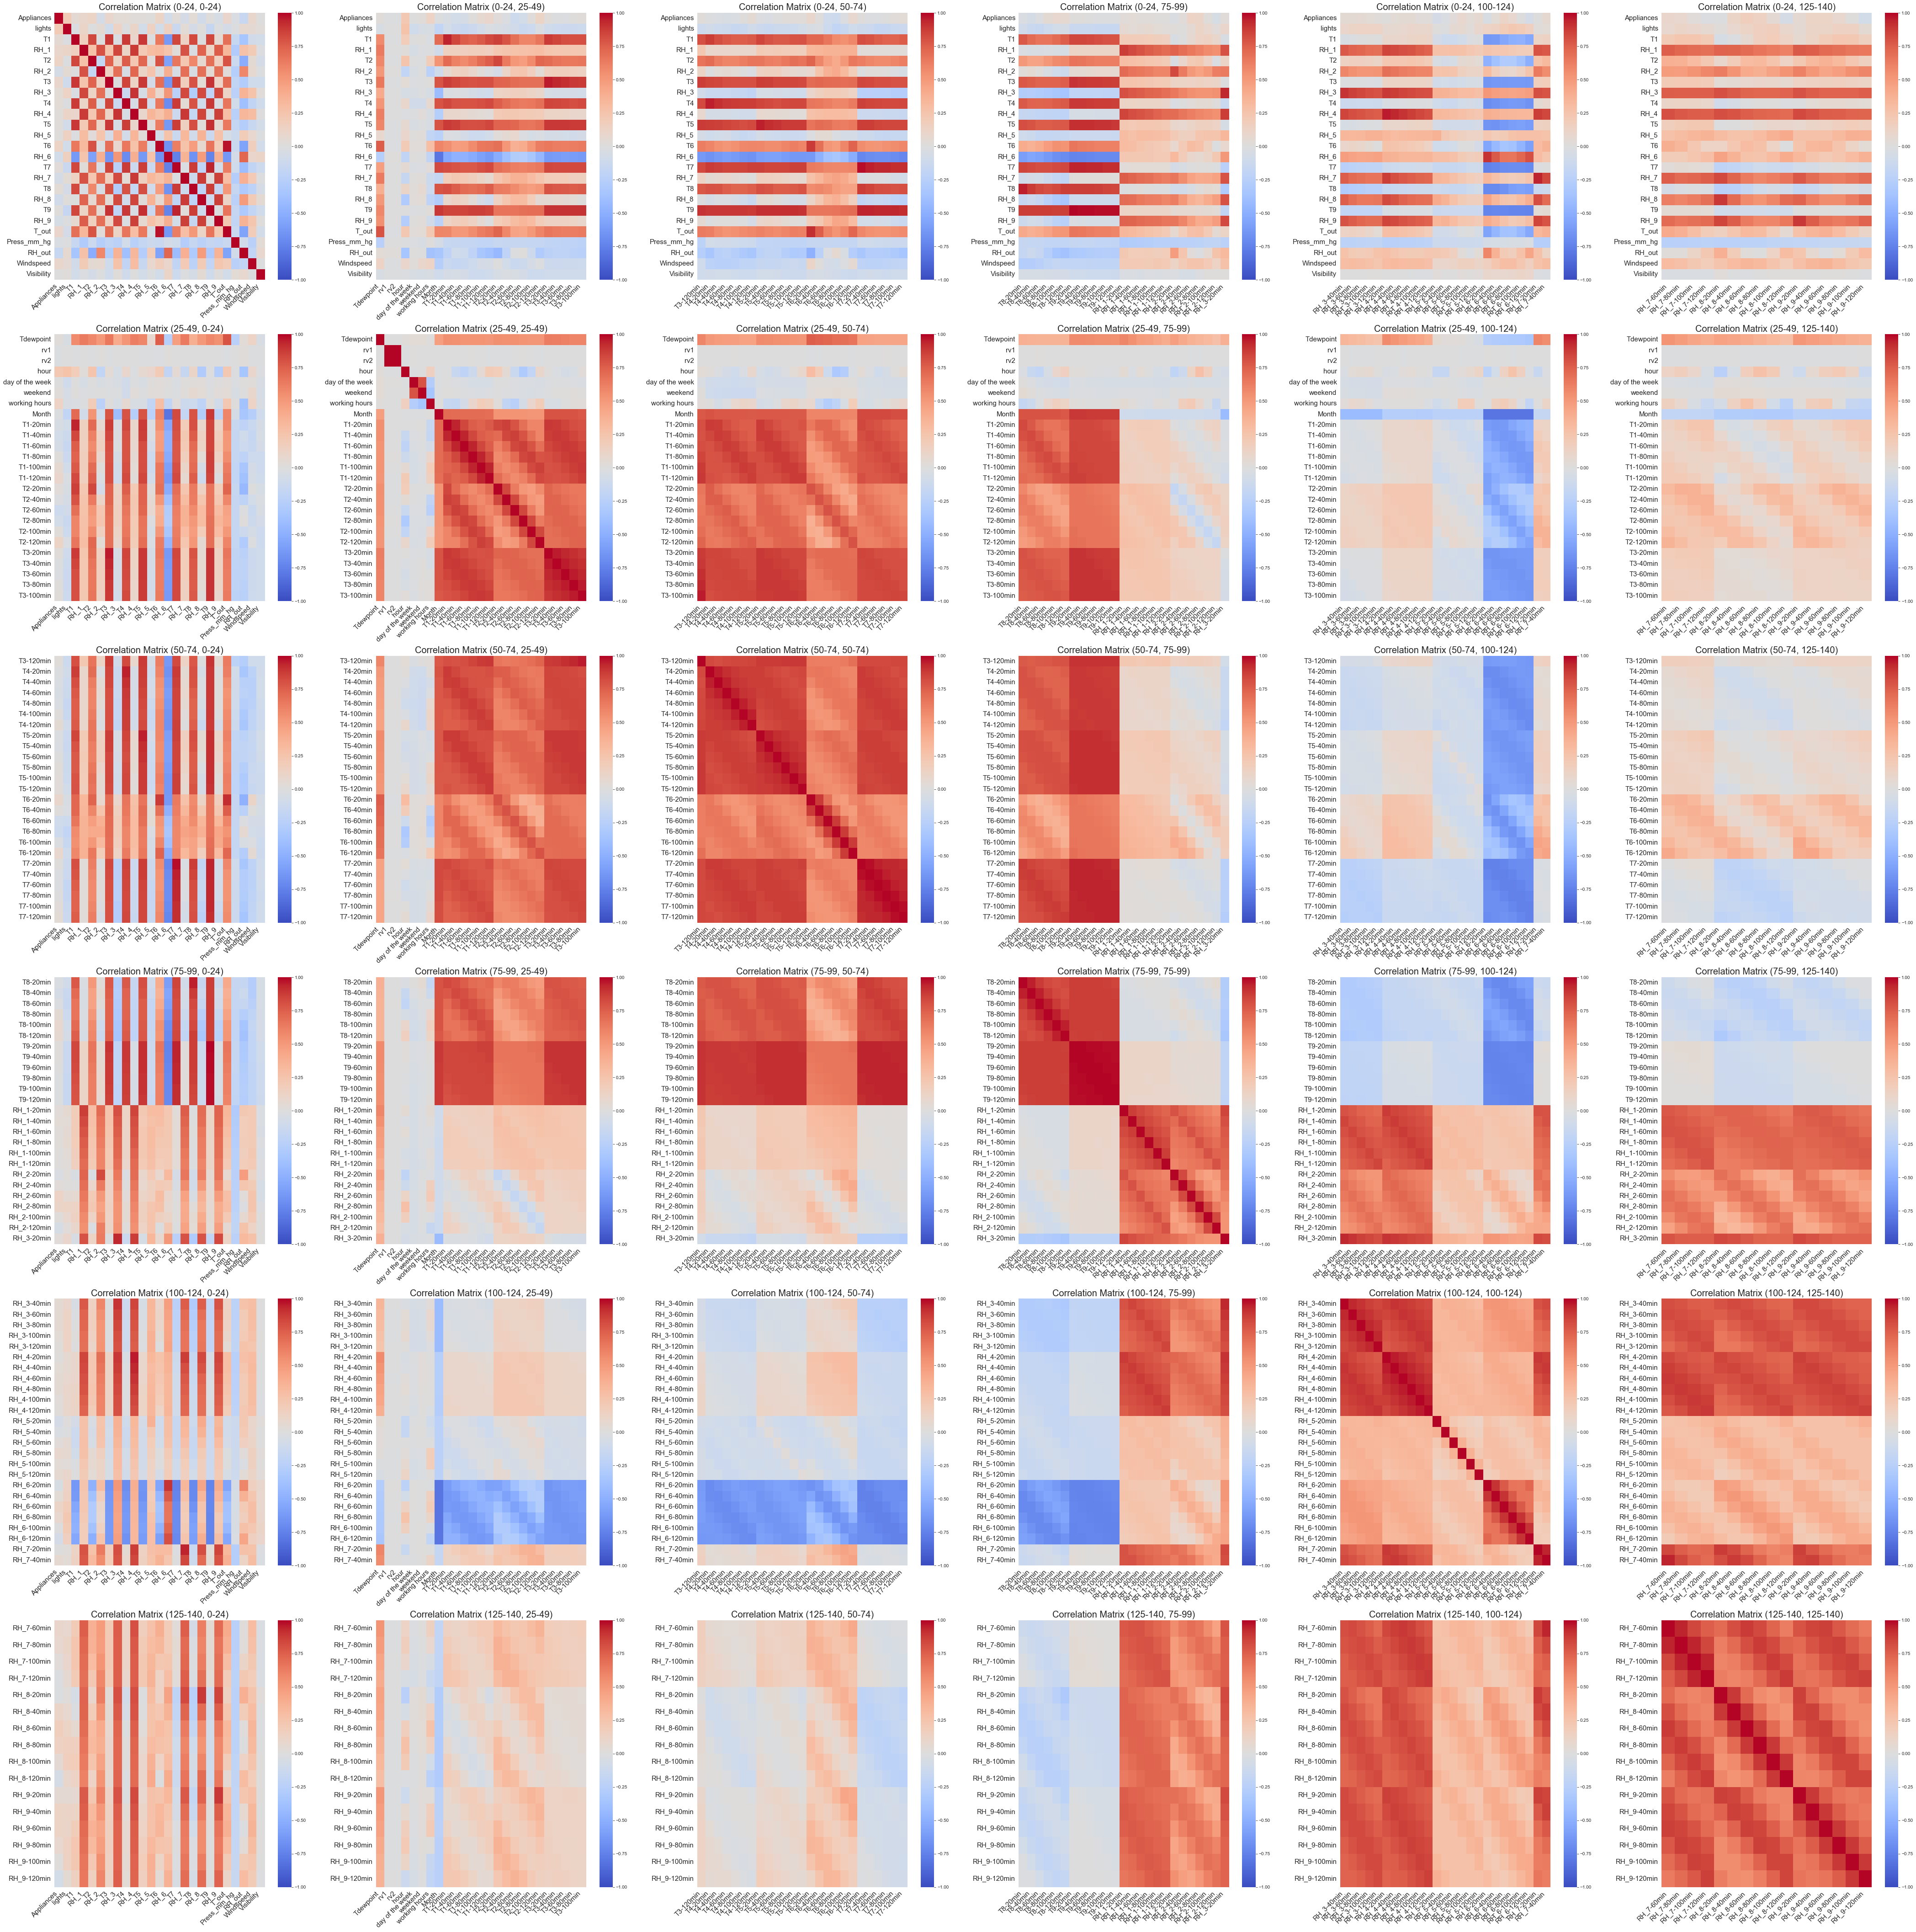

<Figure size 432x288 with 0 Axes>

In [69]:
rounded_corr=my_DF.corr().round(2)
# Set the parameters for dividing the matrix into smaller sections
n_features = 141
chunk_size = 25
n_subplots = int(np.ceil(n_features / chunk_size))

# Create subplots
fig, axes = plt.subplots(n_subplots, n_subplots, figsize=(60, 60))
fig.tight_layout(pad=10)

# Create the heatmaps in each subplot
for i in range(n_subplots):
    for j in range(n_subplots):
        start_col = j * chunk_size
        end_col = min(start_col + chunk_size, n_features)
        start_row = i * chunk_size
        end_row = min(start_row + chunk_size, n_features)

        if start_col < n_features and start_row < n_features:
            subset_corr = rounded_corr.iloc[start_row:end_row, start_col:end_col]
            sns.heatmap(subset_corr, annot=False, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[i, j])

            axes[i, j].set_title(f"Correlation Matrix ({start_row}-{end_row-1}, {start_col}-{end_col-1})", fontsize=20)
            axes[i, j].set_xticks(np.arange(subset_corr.shape[1]) + 0.5)
            axes[i, j].set_xticklabels(subset_corr.columns, rotation=45, ha="right", fontsize=15)

            # Update the y-axis ticks and tick labels
            axes[i, j].set_yticks(np.arange(subset_corr.shape[0]) + 0.5)
            axes[i, j].set_yticklabels(subset_corr.index, fontsize=15)
        else:
            axes[i, j].axis('off')

# Show the plot
plt.show()
plt.savefig('figures/Correlation-Matrix.png')

## Feature engineering/extraction
Defining the required functions for performing the feature selection


In [12]:
def WAPE (y_true, y_pred):
    '''Weighted Absolute Percentage Error (WAPE) between two sets of values: y_true and y_pred'''
    df_y_true=y_true.copy()
    df_y_pred=y_pred.copy()
    df_y_pred.columns=df_y_true.columns
    WAPE=100*np.sum(np.abs(df_y_pred - df_y_true))/np.sum(np.abs(df_y_true))
    return  round(WAPE[0],2)

In [13]:
def acc_timeseriessplit(X,Y,model,cv):
    '''the average Weighted Absolute Percentage Error (WAPE) for a given model using time series cross-validation'''
    tscv = TimeSeriesSplit(n_splits=cv)
    acc = []
    for train_index, valid_index in tscv.split(X):
        X_train, X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
        Y_train, Y_valid = Y.iloc[train_index,:], Y.iloc[valid_index,:]
    model.fit(X_train, Y_train)
    Y_valid_predicted=pd.DataFrame(index=Y_valid.index)
    Y_valid_predicted['pred'] = model.predict(X_valid)
    accuracy =WAPE(Y_valid,Y_valid_predicted)
    acc.append(accuracy)
    return np.average(acc)

In [14]:
def plot_y_feat (WAPE_features , plt_name = 'Name [-]' ):
    plt.figure(1,figsize=(13,5))
    plt.style.use('seaborn-whitegrid')
    plt.axis ('auto')
    plt.plot(np.arange(len(WAPE_features.index)), np.array(WAPE_features), color = 'blue',  markersize = 5, linestyle = '-')
    plt.xticks(np.arange(len(WAPE_features.index)),WAPE_features.index, rotation=40, fontsize=8,horizontalalignment="right", wrap=True)
    plt.ylabel('WAPE [%]', wrap=True)
    fig = plt.figure(1)
    fig.canvas.set_window_title(plt_name)


In [66]:
def feature_sel_1 (model,Features,Target,Save_address=None,cv=10):
    '''This function performs a stepwise feature selection procedure based on the correlation between input features and the target variable. It aims to find the optimal set of features that minimizes the Weighted Absolute Percentage Error (WAPE) for a given model (model) using time series cross-validation. '''

    #Find the correlation matrix, and find the abs(correlation) of each feature with the target
    correlation = abs((pd.concat((Features,Target), axis = 1).corr())[Target.columns[0]]).sort_values(ascending=False).dropna().drop(Target.columns[0])
    correlation_list  = list(correlation.index)

    # Order the features based on the corresponding correlation
    DF_Features=pd.DataFrame(index = Features.index)
    FeatureSelection = pd.Series(index = correlation_list)
    for feat in correlation_list:
        DF_Features= pd.concat((DF_Features, Features[feat]), axis=1)
        FeatureSelection[feat]=acc_timeseriessplit(DF_Features,Target,model,cv)

    #choose the set of features which leads to minimum WAPE

    FeatureSelection_selected = FeatureSelection[:(str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",''))]

    #among the remaining features, the ones that increase the overall obtained error are discarded
    FeatureSelection_neg = FeatureSelection
    for feat in  correlation_list[1:]:
        if ((FeatureSelection.shift(+1)).loc[feat]) >= (FeatureSelection.loc[feat]):
          continue
        else:
          FeatureSelection_neg = FeatureSelection_neg.drop([feat])

    FeatureSelection_neg_after = FeatureSelection_neg[(str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",'')):].drop((str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",'')))

    #the remaining ones are sorted in a descending order based on the overall error obtained while adding them.
    FeatureSelection_selected = pd.concat((FeatureSelection_neg_after.sort_values(ascending=False),FeatureSelection_selected.sort_values(ascending=False)), axis = 0)

    #Plot and save the figure
    plt_name ='selected_features_step1'+'.png'
    plot_y_feat(FeatureSelection , plt_name = plt_name)
    plt.savefig('figures/selected_features_step1.png')
    plt.show()

    return FeatureSelection_selected

In [16]:
def feature_sel_2(model,Features,Target,FeatureSelection,Save_address=None,cv=10):

    '''This second step of feature selection aims to further refine the feature set by evaluating the features in a different order.'''

    #Selection of the features according to their WAPE
    DF_features_selected = Features[FeatureSelection.index]

    #reverse the order of columns
    DF_features_selected=DF_features_selected.iloc[:, ::-1]

    #same as previous step features are added gradually and the obtained WAPE is monitored
    FeatureSelection = pd.Series(index = DF_features_selected.columns)
    DF_Features=pd.DataFrame(index = Features.index)
    for feat in DF_features_selected.columns:
        DF_Features= pd.concat((DF_Features, DF_features_selected[feat]), axis=1)
        FeatureSelection[feat]=acc_timeseriessplit(DF_Features,Target,model,cv)

    #Selecting the set of features which leads to minmum WAPE
    FeatureSelection_selected_updated = FeatureSelection[:(str(FeatureSelection[(FeatureSelection == FeatureSelection.min())].index.values.tolist()).replace("['",'').replace("']",''))]

    #Plot and save the figure
    plt_name ='selected_features_step2'+'.png'
    plot_y_feat(FeatureSelection , plt_name = plt_name)
    plt.savefig('figures/selected_features_step2.png')
    plt.show()

    return FeatureSelection_selected_updated

In [17]:
def feature_sel_3(algorithm,Features,Target,FeatureSelection,Save_address=None,cv=10):
    '''The third step of feature selection aims to further refine the feature set by iteratively evaluating each remaining feature and selecting the one that yields the lowest WAPE value in each iteration. This can result in a more optimal set of features for the given model.'''

    DataSet_features=Features[FeatureSelection.index]
    DF_features=DataSet_features.copy()
    features=pd.DataFrame(index=DataSet_features.index)
    Final_WAPE_results=pd.Series()

    for i in range(len(DataSet_features.columns)) :
        WAPE_values_this_iter=pd.Series()
        for feat in DF_features.columns :
            features = pd.concat((features,DataSet_features[feat]),axis=1)
            WAPE_values_this_iter[feat]=acc_timeseriessplit(features,Target,algorithm,cv)
            features = features.drop(feat,axis=1)

        features = pd.concat((features,DataSet_features[WAPE_values_this_iter.idxmin()]),axis=1)
        DF_features = DF_features.drop(WAPE_values_this_iter.idxmin(),axis=1)
        Final_WAPE_results[WAPE_values_this_iter.idxmin()]=WAPE_values_this_iter.min()
    FeatureSelection_final = Final_WAPE_results[:(str(Final_WAPE_results[(Final_WAPE_results == Final_WAPE_results.min())].index.values.tolist()).replace("['",'').replace("']",''))]
    DF_features_selected_Final = DataSet_features[FeatureSelection_final.index]
 
    #Plot and save the figure
    plt_name ='selected_features_step3'+'.png'
    plot_y_feat(Final_WAPE_results)
    plt.savefig('figures/selected_features_step3.png')
    plt.show()

    return DF_features_selected_Final

## Feature Selection

In this section, feature selection is performed using Random Forest algorithm and three different selection types.

In [18]:
y=my_DF[["RH_1"]]
X=my_DF.drop(columns=["RH_1"])

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)
# The last 20% is used as the test, without shuffling

concat_DF=pd.concat((X_train_val,y_train_val),axis=1)

# concat_DF
correlation_vect=abs(concat_DF.corr()["RH_1"])
correlation_vect_sorted=correlation_vect.sort_values (ascending=False)
correlation_vect_sorted=correlation_vect_sorted.drop("RH_1")
A=correlation_vect_sorted>0.7

correlation_vect_edited=correlation_vect_sorted[A]
correlation_vect_edited.index

X_train_val=X_train_val[correlation_vect_edited.index]

X_test=X_test[correlation_vect_edited.index]

#implementing the feature selection using Random Forest algorithm
RF_reg = RandomForestRegressor()

**Having defined the viable features to be chosen, the three available selection methods are evaluated in the following.**

In [67]:
featureSelection_1= feature_sel_1(RF_reg,X_train_val, y_train_val,cv=10)

KeyError: "RH_8-40min', 'RH_9-60min', 'RH_7-100min"

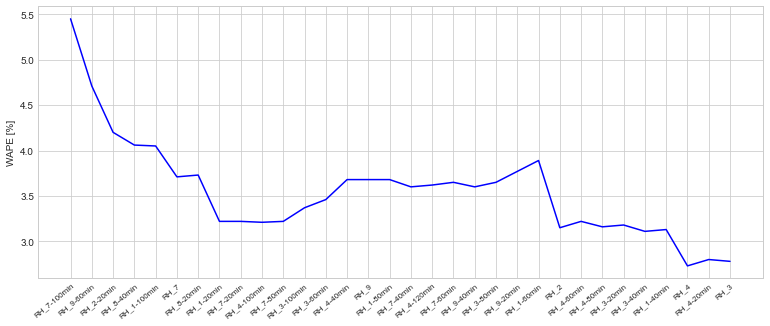

In [43]:
feature_selection_2 = feature_sel_2(RF_reg,X_train_val,y_train_val,featureSelection_1, cv=10)

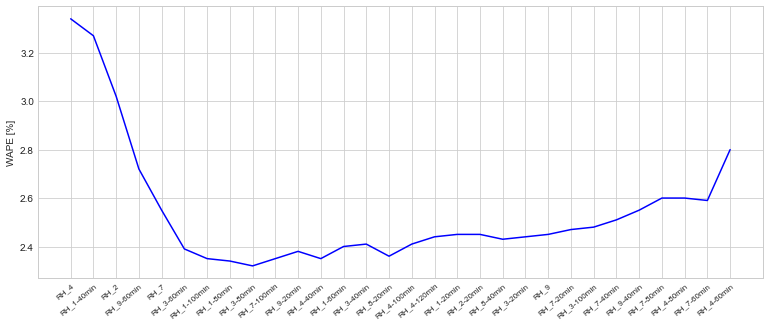

In [46]:
df_selected_features = feature_sel_3(RF_reg,X_train_val,y_train_val,feature_selection_2,cv=10)

In [ ]:
a=set(df_selected_features.columns)
b=set(feature_selection_2.index)
c=set(featureSelection_1.index)
mutual_indexes=a.intersection(b,c)
print(mutual_indexes)

In [20]:
selected_features=['RH_2', 'RH_3-80min', 'RH_7', 'RH_1-40min', 'RH_1-80min', 'RH_9-60min', 'RH_1-100min', 'RH_3-60min', 'RH_4']

WAPE_sel_feat_val  = acc_timeseriessplit(X_train_val[selected_features],y_train_val,RF_reg,cv=10)
RF_reg.fit(X_train_val[selected_features],y_train_val)
y_test_predicted_sel_feat= pd.DataFrame(index=y_test.index)
y_test_predicted_sel_feat["real"] = y_test["RH_1"]
y_test_predicted_sel_feat["pred"] = RF_reg.predict(X_test[selected_features])
WAPE_sel_feat_test= WAPE(y_test_predicted_sel_feat[["real"]],y_test_predicted_sel_feat[["pred"]])

df_accuracy = pd.DataFrame(columns=["Validation","Test","Features"])
df_accuracy.loc["Selected Feature","Test"] = WAPE_sel_feat_test
df_accuracy.loc["Selected Feature","Validation"]= WAPE_sel_feat_val
df_accuracy.loc["Selected Feature","Features"]= str(list(selected_features))

In [21]:
df_accuracy

Validation  Test  \
Selected Feature       2.34  3.93   

                                                           Features  
Selected Feature  ['RH_2', 'RH_3-80min', 'RH_7', 'RH_1-40min', '...

## Linear Regression

In [22]:
#choosing targets and features
target=my_DF["RH_1"]
features=selected_features

#choosing the test,validation and trainining data
test_target=y_test
test_features=X_test[selected_features]
training_DF=X_train_val[selected_features].loc["2016-01-12":"2016-03-30"]
validation_DF=X_train_val[selected_features].loc["2016-04-01":"2016-04-30"]

In [23]:
#fitting linear regression on the data
linear_reg=linear_model.LinearRegression()
training_target=y_train_val.loc["2016-01-12":"2016-03-30"]
training_features=training_DF

linear_reg.fit(training_features,training_target)

LinearRegression()

In [24]:
#creating the validation features and target
validation_target=y_train_val.loc["2016-04-01":"2016-04-30"]
validation_features=validation_DF
predicted_RH_1_validation_LR=linear_reg.predict(validation_features)

<AxesSubplot:title={'center':'Real value vs. Validated data (LinearRegression)'}, xlabel='date'>

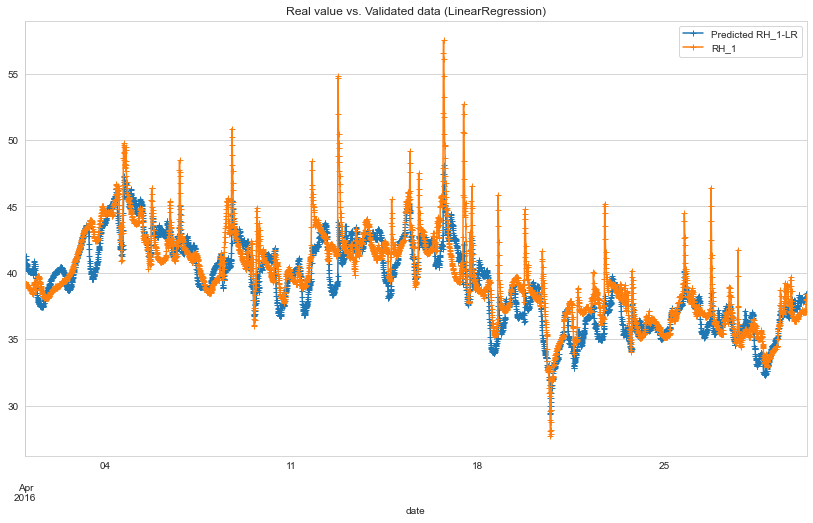

In [25]:
#comparing the real value with the validated data

Comparison_DF=pd.DataFrame(predicted_RH_1_validation_LR,index=validation_target.index,columns=["Predicted RH_1-LR"])
Comparison_DF=Comparison_DF.join(validation_target)
Comparison_DF.plot(marker="+",figsize=(14,8),title='Real value vs. Validated data (LinearRegression)')
plt.savefig('figures/RvV-LR.png')

In [26]:
#calculating the performance metrics

MAE_LR_validation=mean_absolute_error(predicted_RH_1_validation_LR,validation_target)
MSE_LR_validation=mean_squared_error(predicted_RH_1_validation_LR,validation_target)
R2_LR_validation=r2_score(predicted_RH_1_validation_LR,validation_target)

print("MAE_LR: "+str(round(MAE_LR_validation,2)))
print("MSE_LR: "+str(round(MSE_LR_validation,2)))
print("R2 Score_LR: "+str(round(R2_LR_validation,4)))

MAE_LR: 1.21
MSE_LR: 2.82
R2 Score_LR: 0.7194


## Random Forest

In [27]:
#applying Random Forest Model
from sklearn.ensemble import RandomForestRegressor
RF_reg = RandomForestRegressor()

In [28]:
RF_reg.fit(training_features,training_target)
predicted_RH_1_validation_RF = RF_reg.predict(validation_features)

<AxesSubplot:title={'center':'Real value vs. Validated data (Random Forest)'}, xlabel='date'>

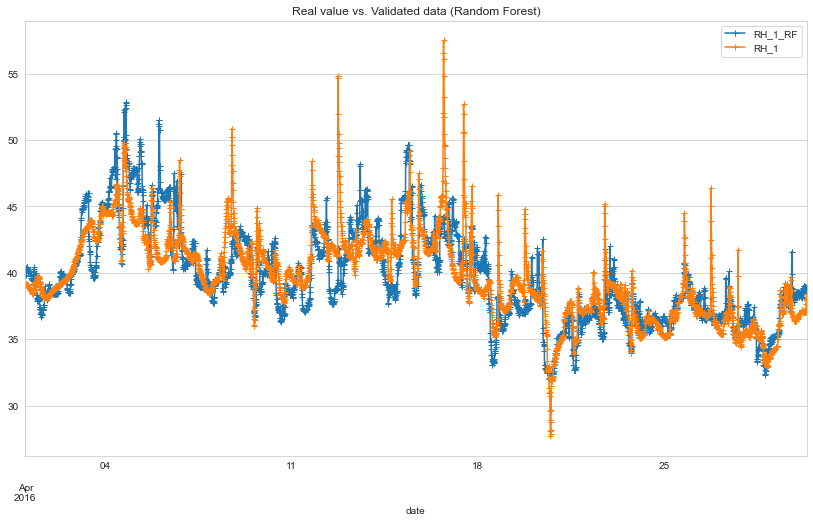

In [29]:
#comparing the real values compared with the ones estimated by RF_reg
Comparison_DF_RF=pd.DataFrame(predicted_RH_1_validation_RF,index=validation_target.index,columns=["RH_1_RF"])
Comparison_DF_RF=Comparison_DF_RF.join(validation_target)
Comparison_DF_RF.plot(marker="+",figsize=(14,8),title='Real value vs. Validated data (Random Forest)')
plt.savefig('figures/RvV-RF.png')

In [30]:
##calculating the performance metrics

MAE_RF_validation=mean_absolute_error(predicted_RH_1_validation_RF,validation_target)
MSE_RF_validation=mean_squared_error(predicted_RH_1_validation_RF,validation_target)
R2_RF_validation=r2_score(predicted_RH_1_validation_RF,validation_target)

print("MAE_LR: "+str(round(MAE_RF_validation,2)))
print("MSE_RF: "+str(round(MSE_RF_validation,2)))
print("R2 Score_RF: "+str(round(R2_RF_validation,4)))

MAE_LR: 1.52
MSE_RF: 4.33
R2 Score_RF: 0.6594


## XGboost

In [31]:
model = XGBRegressor(n_estimators=100,max_depth=7,eta=0.1,subsample=0.7,colsample_bytree=0.8,silent=1)

model.fit(training_features,training_target)
predicted_RH_1_validation_XGboost=model.predict(validation_features)

[13:22:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



<AxesSubplot:title={'center':'Real value vs. Validated data (XGboost)'}, xlabel='date'>

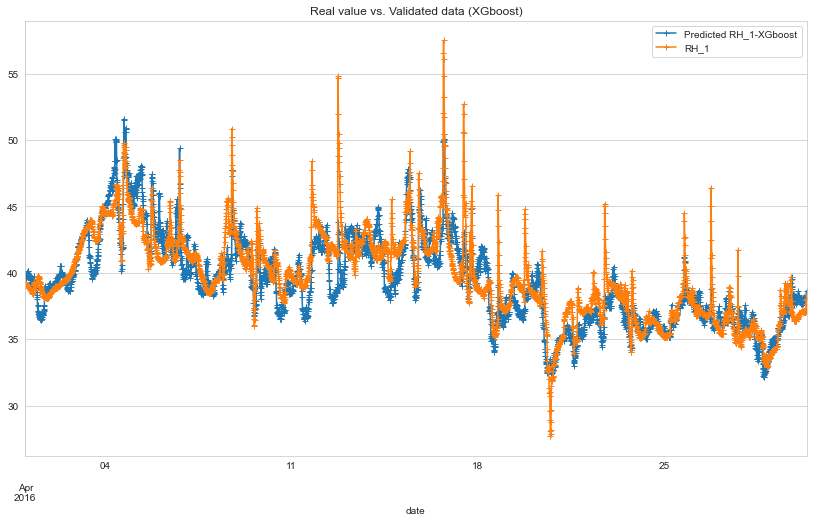

In [33]:
Comparison_DF=pd.DataFrame(predicted_RH_1_validation_XGboost,index=validation_target.index,columns=["Predicted RH_1-XGboost"])

Comparison_DF=Comparison_DF.join(validation_target)

Comparison_DF.plot(marker="+",figsize=(14,8),title='Real value vs. Validated data (XGboost)')
plt.savefig('figures/RvV-XG.png')

In [34]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_XG_validation=mean_absolute_error(predicted_RH_1_validation_XGboost,validation_target)
MSE_XG_validation=mean_squared_error(predicted_RH_1_validation_XGboost,validation_target)
R2_XG_validation=r2_score(predicted_RH_1_validation_XGboost,validation_target)

print("MAE_LR: "+str(round(MAE_XG_validation,2)))
print("MSE_LR: "+str(round(MSE_XG_validation,2)))
print("R2 Score_LR: "+str(round(R2_XG_validation,4)))

MAE_LR: 1.29
MSE_LR: 3.02
R2 Score_LR: 0.7205


**Having analyzed the performance matrices, XGboost is chosen as the promising model and the model is fitted for the test section**

In [35]:
model.fit(X_train_val[selected_features],y_train_val)
predicted_RH_1_test=model.predict(X_test[selected_features])

[13:23:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



<AxesSubplot:title={'center':'Real value vs. Validated data (XGboost)'}, xlabel='date'>

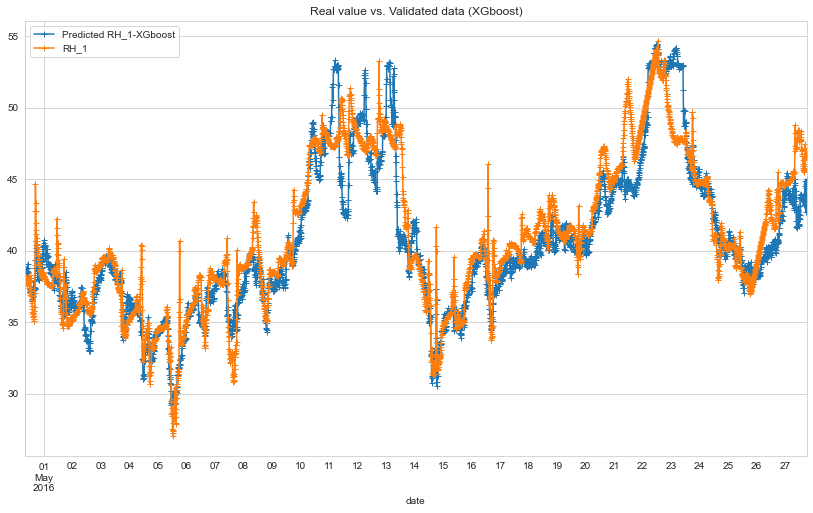

In [36]:
Comparison_DF=pd.DataFrame(predicted_RH_1_test,index=test_target.index,columns=["Predicted RH_1-XGboost"])
Comparison_DF=Comparison_DF.join(test_target)
Comparison_DF.plot(marker="+",figsize=(14,8),title='Real value vs. Tested data (XGboost)')
plt.savefig('figures/RvT-LR.png')

In [38]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_XGT_validation=mean_absolute_error(predicted_RH_1_test,test_target)
MSE_XGT_validation=mean_squared_error(predicted_RH_1_test,test_target)
R2_XGT_validation=r2_score(predicted_RH_1_test,test_target)

print("MAE_LR: "+str(round(MAE_XGT_validation,2)))
print("MSE_LR: "+str(round(MSE_XGT_validation,2)))
print("R2 Score_LR: "+str(round(R2_XGT_validation,4)))


MAE_LR: 1.48
MSE_LR: 4.28
R2 Score_LR: 0.8404


## The same procedure is performend without feature selection and the results are compared.


## Linear Regression

In [39]:
y=my_DF[["RH_1"]]
X=my_DF.drop(columns=["RH_1"])

In [40]:
#choosing targets and features

target=my_DF["RH_1"]
features=my_DF.drop("RH_1", axis=1)

#choosing the test,validation and trainining data
test_target=y_test
test_features=X_test
training_DF=X_train_val.loc["2016-01-12":"2016-03-30"]
validation_DF=X_train_val.loc["2016-04-01":"2016-04-30"]

In [41]:
#fitting linear regression on the data

linear_reg=linear_model.LinearRegression()
training_target=y_train_val.loc["2016-01-12":"2016-03-30"]
training_features=training_DF

linear_reg.fit(training_features,training_target)

LinearRegression()

In [42]:
#creating the validation features and target

validation_target=y_train_val.loc["2016-04-01":"2016-04-30"]
validation_features=validation_DF

predicted_RH_1_validation_LR1=linear_reg.predict(validation_features)

<AxesSubplot:title={'center':'Real value vs. Validated data (LinearRegression)'}, xlabel='date'>

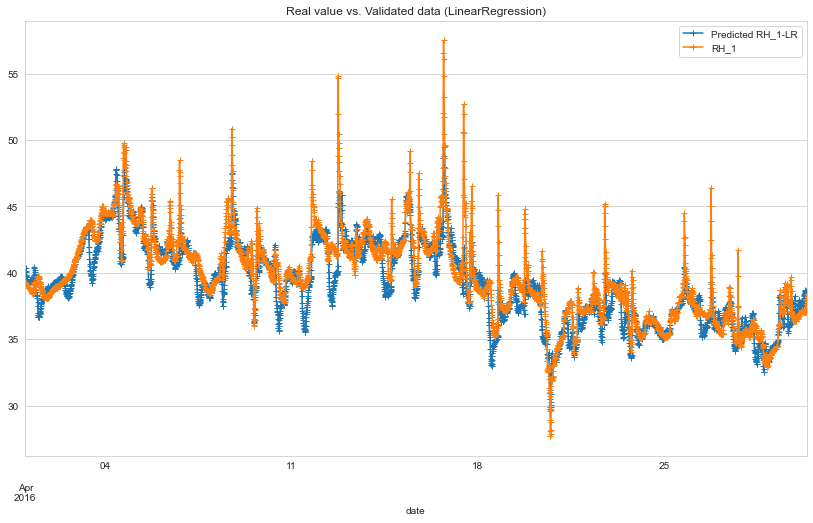

In [43]:
#comparing the real value with the validated data

Comparison_DF=pd.DataFrame(predicted_RH_1_validation_LR1,index=validation_target.index,columns=["Predicted RH_1-LR"])

Comparison_DF=Comparison_DF.join(validation_target)

Comparison_DF.plot(marker="+",figsize=(14,8),title='Real value vs. Validated data (LinearRegression)')
plt.savefig('figures/RvV-LR-nofeat.png')

In [44]:
#calculating the performance metrics

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_LR1_validation=mean_absolute_error(predicted_RH_1_validation_LR1,validation_target)
MSE_LR1_validation=mean_squared_error(predicted_RH_1_validation_LR1,validation_target)
R2_LR1_validation=r2_score(predicted_RH_1_validation_LR1,validation_target)

print("MAE_LR: "+str(round(MAE_LR1_validation,2)))
print("MSE_LR: "+str(round(MSE_LR1_validation,2)))
print("R2 Score_LR: "+str(round(R2_LR1_validation,4)))

MAE_LR: 0.96
MSE_LR: 2.14
R2 Score_LR: 0.767


##Random Forest

In [45]:
RF_reg = RandomForestRegressor()
RF_reg.fit(training_features,training_target)
predicted_RH_1_validation_RF1 = RF_reg.predict(validation_features)

<AxesSubplot:title={'center':'Real value vs. Validated data (Random Forest)'}, xlabel='date'>

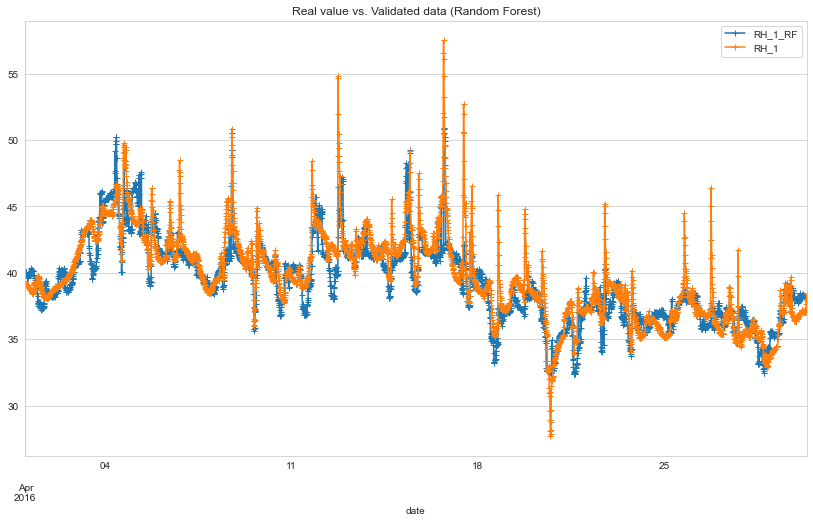

In [46]:
#comparing the real values compared with the ones estimated by RF_reg

Comparison_DF_RF=pd.DataFrame(predicted_RH_1_validation_RF1,index=validation_target.index,columns=["RH_1_RF"])
Comparison_DF_RF=Comparison_DF_RF.join(validation_target)
Comparison_DF_RF.plot(marker="+",figsize=(14,8),title='Real value vs. Validated data (Random Forest)')
plt.savefig('figures/RvV-RF-nofeat.png')

In [47]:
##calculating the performance metrics

MAE_RF1_validation=mean_absolute_error(predicted_RH_1_validation_RF1,validation_target)
MSE_RF1_validation=mean_squared_error(predicted_RH_1_validation_RF1,validation_target)
R2_RF1_validation=r2_score(predicted_RH_1_validation_RF1,validation_target)

print("MAE_LR: "+str(round(MAE_RF1_validation,2)))
print("MSE_RF: "+str(round(MSE_RF1_validation,2)))
print("R2 Score_RF: "+str(round(R2_RF1_validation,4)))

MAE_LR: 1.12
MSE_RF: 2.55
R2 Score_RF: 0.7188


## XGboost

In [48]:
model = XGBRegressor(n_estimators=100,max_depth=7,eta=0.1,subsample=0.7,colsample_bytree=0.8,silent=1)

model.fit(training_features,training_target)
predicted_RH_1_validation=model.predict(validation_features)

[13:27:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [49]:
validation_target=y_train_val.loc["2016-04-01":"2016-04-30"]
validation_features=validation_DF

predicted_RH_1_validation_XGboost1=model.predict(validation_features)

<AxesSubplot:title={'center':'Real value vs. Validated data (XGboost)'}, xlabel='date'>

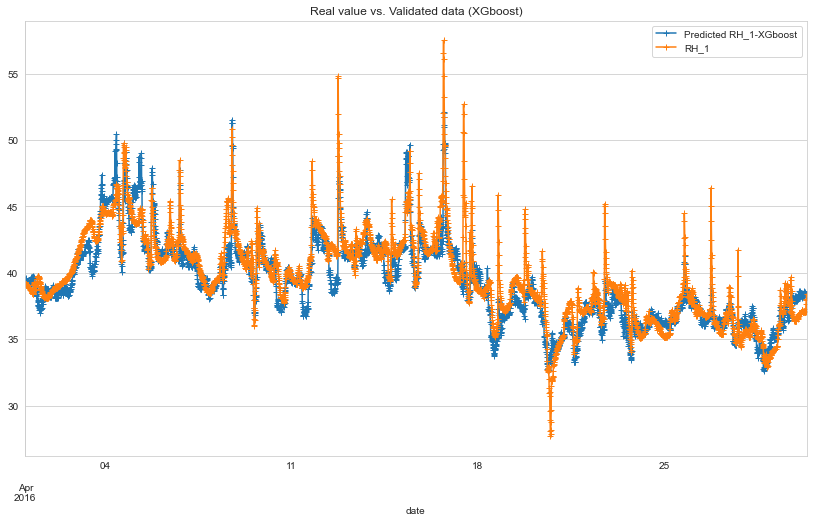

In [51]:
Comparison_DF=pd.DataFrame(predicted_RH_1_validation_XGboost1,index=validation_target.index,columns=["Predicted RH_1-XGboost"])

Comparison_DF=Comparison_DF.join(validation_target)

Comparison_DF.plot(marker="+",figsize=(14,8),title='Real value vs. Validated data (XGboost)')
plt.savefig('figures/RvV-XG-nofeat.png')

In [52]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_XG1_validation=mean_absolute_error(predicted_RH_1_validation_XGboost1,validation_target)
MSE_XG1_validation=mean_squared_error(predicted_RH_1_validation_XGboost1,validation_target)
R2_XG1_validation=r2_score(predicted_RH_1_validation_XGboost1,validation_target)

print("MAE_XG1: "+str(round(MAE_XG1_validation,2)))
print("MSE_XG1: "+str(round(MSE_XG1_validation,2)))
print("R2 Score_XG1: "+str(round(R2_XG1_validation,4)))

MAE_XG1: 1.04
MSE_XG1: 2.19
R2 Score_XG1: 0.7761


In [53]:
#fitting the target with XGboost
model.fit(X_train_val,y_train_val)
predicted_RH_1_test_1=model.predict(X_test)

[13:30:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



<AxesSubplot:title={'center':'Real value vs. Tested data (XGboost)'}, xlabel='date'>

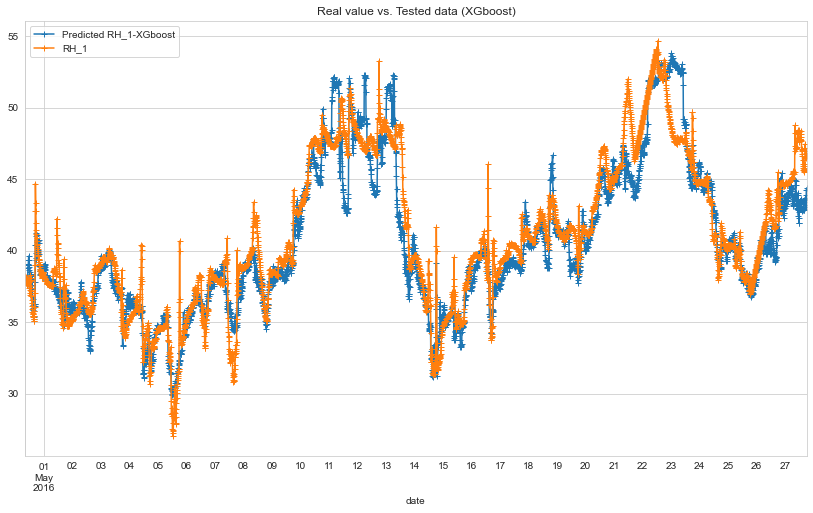

In [54]:
Comparison_DF=pd.DataFrame(predicted_RH_1_test_1,index=test_target.index,columns=["Predicted RH_1-XGboost"])
Comparison_DF=Comparison_DF.join(test_target)
Comparison_DF.plot(marker="+",figsize=(14,8),title='Real value vs. Tested data (XGboost)')
plt.savefig('figures/RvT-XG-nofeat.png')

In [56]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
MAE_XGT1_validation=mean_absolute_error(predicted_RH_1_test_1,test_target)
MSE_XGT1_validation=mean_squared_error(predicted_RH_1_test_1,test_target)
R2_XGT1_validation=r2_score(predicted_RH_1_test_1,test_target)

print("MAE_XGT1: "+str(round(MAE_XGT1_validation,2)))
print("MSE_XGT1: "+str(round(MSE_XGT1_validation,2)))
print("R2 Score_XGT1: "+str(round(R2_XGT1_validation,4)))

MAE_XGT1: 1.34
MSE_XGT1: 3.53
R2 Score_XGT1: 0.8645


##Having performed all the steps, the derived parameters are now compared.

In [57]:
headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Performance Metrics</b>','<b>SF_LR</b>','<b>SF_RF</b>','<b>SF_XG</b>','<b>Target_XG</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      ['MAE', 'MSE', 'R2 Score'],
      [MAE_LR_validation,MSE_LR_validation ,R2_LR_validation],
     [MAE_RF_validation,MSE_RF_validation ,R2_RF_validation],
      [MAE_XG_validation,MSE_XG_validation ,R2_XG_validation],
      [MAE_XGT_validation,MSE_XGT_validation ,R2_XGT_validation]],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*5],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.show()

In [58]:
headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Performance Metrics</b>','<b>AF_LR</b>','<b>AF_RF</b>','<b>AF_XG</b>','<b>Target_XG</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      ['MAE', 'MSE', 'R2 Score'],
      [MAE_LR1_validation,MSE_LR1_validation ,R2_LR1_validation],
     [MAE_RF1_validation,MSE_RF1_validation ,R2_RF1_validation],
      [MAE_XG1_validation,MSE_XG1_validation ,R2_XG1_validation],
      [MAE_XGT1_validation,MSE_XGT1_validation ,R2_XGT1_validation]],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*5],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.show()

##In the following, the value of WAPE is calculated for the exploited models (using both the selected features and all the features)

In [59]:
selected_features=['RH_2', 'RH_3-80min', 'RH_7', 'RH_1-40min', 'RH_1-80min', 'RH_9-60min', 'RH_1-100min', 'RH_3-60min', 'RH_4']
WAPE_sel_feat_val_LR  = acc_timeseriessplit(X_train_val[selected_features],y_train_val,linear_reg,cv=10)
WAPE_sel_feat_val_RF  = acc_timeseriessplit(X_train_val[selected_features],y_train_val,RF_reg,cv=10)
WAPE_sel_feat_val_XGboost  = acc_timeseriessplit(X_train_val[selected_features],y_train_val,model,cv=10)

[18:46:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [60]:
WAPE_sel_feat_val_LR_allfeatures  = acc_timeseriessplit(X_train_val,y_train_val,linear_reg,cv=10)
WAPE_sel_feat_val_RF_allfeatures  = acc_timeseriessplit(X_train_val,y_train_val,RF_reg,cv=10)
WAPE_sel_feat_val_XGboost_allfeatures  = acc_timeseriessplit(X_train_val,y_train_val,model,cv=10)

[18:46:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [61]:
#The derived values ar then represnted in a dataframe
headerColor = 'grey'
rowEvenColor = 'lightgrey'
rowOddColor = 'white'

fig = go.Figure(data=[go.Table(
  header=dict(
    values=['<b>Model</b>','<b>WAPE_Selected features</b>','<b>WAPE_All features</b>'],
    line_color='darkslategray',
    fill_color=headerColor,
    align=['left','center'],
    font=dict(color='white', size=12)
  ),
  cells=dict(
    values=[
      ['LR', 'RF', 'XGboost'],
      [WAPE_sel_feat_val_LR,WAPE_sel_feat_val_RF ,WAPE_sel_feat_val_XGboost ],
       [WAPE_sel_feat_val_LR_allfeatures,WAPE_sel_feat_val_RF_allfeatures ,WAPE_sel_feat_val_XGboost_allfeatures ]
    ],
    line_color='darkslategray',
    # 2-D list of colors for alternating rows
    fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*5],
    align = ['left', 'center'],
    font = dict(color = 'darkslategray', size = 11)
    ))
])

fig.show()

##In the Following the predicted data using XGboost algorithm is compared to the real data.

In [62]:
y_test_pred_selected_feat= pd.DataFrame(index=y_test.index)
y_test_pred_selected_feat["real"]=y_test["RH_1"]
y_test_pred_selected_feat["pred"]=predicted_RH_1_test

In [63]:
y_test_pred_all_feat= pd.DataFrame(index=y_test.index)
y_test_pred_all_feat["real"]=y_test["RH_1"]
y_test_pred_all_feat["pred"]=predicted_RH_1_test_1

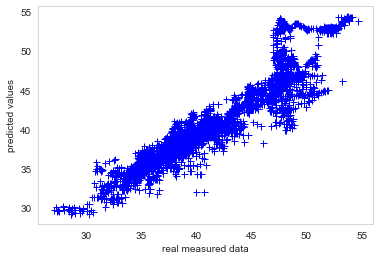

In [64]:
plt.plot(y_test_pred_selected_feat["real"],y_test_pred_selected_feat["pred"],"+", color="b",markersize=7,figsize=(14,8))
plt.xlabel("real measured data")
plt.ylabel("predicted values")
plt.grid()
plt.savefig('figures/RvP-RF.png')